In [3]:
# # GOOGLE COLAB
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/MyDrive/laba')

Mounted at /content/drive


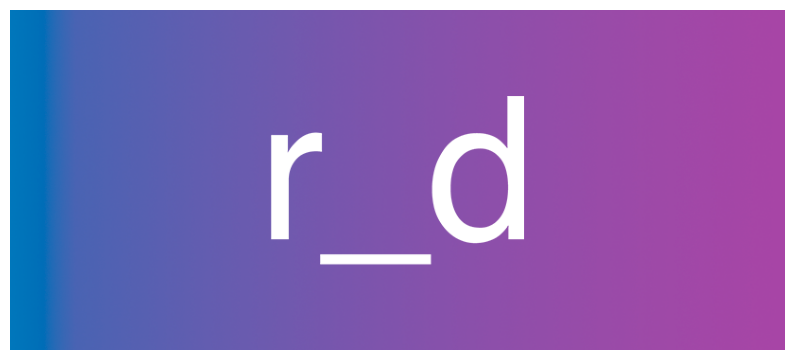

In [4]:
import rd_utils as rdu
rdu.show_logo()

<font size="10">Lekce 2 - domácí úloha</font>

V této domácí úloze si procvičíte regresní úlohu.

**Instrukce:**

 - vyplň všechna místa v kódu, kde je uvedeno "STUDENT"
 - nemaž předvyplněný kód v buňkách (např. `y_clf.head()` nebo  `y_reg_pred[:5]`), aby bylo možné zkontrolovat Tvůj výsledek

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, roc_curve

# Načtení dat

In [7]:
df_raw = pd.read_csv('datasets/medical_cost_personal/insurance.csv')

**Dataset Medical cost personal**

*zdroj: https://www.kaggle.com/datasets/mirichoi0218/insurance*

Dataset "Medical Cost Personal" na Kaggle obsahuje informace o nákladech na zdravotní péči. Tento dataset obsahuje údaje o pacientech, jako jsou věk, pohlaví, kuřáctví, region, počet dětí a další. Hlavním cílem je analyzovat náklady na zdravotní péči v závislosti na těchto faktorech. Tento dataset lze využít k provádění analýz a predikcí v oblasti nákladů na zdravotní péči a může být užitečný pro zdravotní pojišťovny, lékaře a výzkumníky v oblasti zdravotní ekonomiky.

- age: Věk hlavního pojištěnce
- sex: Pohlaví pojišťovatele, žena, muž
- bmi: Index tělesné hmotnosti poskytující pochopení tělesné stavby, hmotnosti, která je relativně vysoká nebo nízká ve vztahu k výšce, objektivní ukazatel tělesné hmotnosti (kg/m^2) pomocí poměru výšky k hmotnosti, ideálně 18,5 až 24,9
- children: Počet dětí pokrytých zdravotním pojištěním / Počet závislých osob
- smoker: Kuřáctví
- region: Místo bydliště příjemce v USA, severovýchod, jihovýchod, jihozápad, severozápad.
- charges: Individuální lékařské náklady fakturované zdravotním pojištěním

In [8]:
df_raw.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Preprocessing dat

- Soupec pro pohlaví (`sex`) je nahrazen 0/1 proměnnou `is_male` (je muž).
- Soupec `smoker` je nahrazen 0/1 proměnnou `is_smoker` (je kuřák).

In [9]:
df = df_raw.copy()
df['is_male'] =  df['sex'].replace({'female': '0', 'male': '1'}).astype(np.int8)
df['is_smoker'] =  df['smoker'].replace({'no': '0', 'yes': '1'}).astype(np.int8)
df.drop(columns=['sex', 'smoker', 'region'], inplace=True)

In [10]:
# upravený dataframe
df.head(5)

,age,bmi,children,charges,is_male,is_smoker
0,19,27.900,0,16884.92400,0,1
1,18,33.770,1,1725.55230,1,0
2,28,33.000,3,4449.46200,1,0
3,33,22.705,0,21984.47061,1,0
4,32,28.880,0,3866.85520,1,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1338 non-null   int64  
 1   bmi        1338 non-null   float64
 2   children   1338 non-null   int64  
 3   charges    1338 non-null   float64
 4   is_male    1338 non-null   int8   
 5   is_smoker  1338 non-null   int8   
dtypes: float64(2), int64(2), int8(2)
memory usage: 44.6 KB


# Průzkumná analýza dat

Použijte funkce `plot_histograms` a `plot_pairplots` z našeho modulu (souboru) `rd_utils` pro vytvoření základní průzkumné analýzy dat. Cílová proměnná `y_var` je `charges` (použijte pouze u `plot_pairplots`).

In [12]:
df.columns

Index(['age', 'bmi', 'children', 'charges', 'is_male', 'is_smoker'], dtype='object')

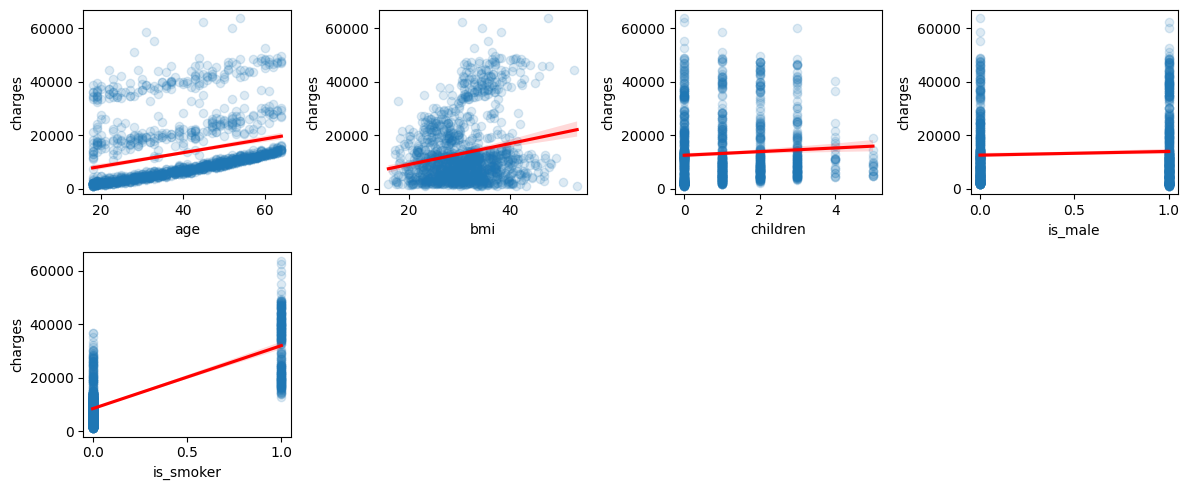

In [13]:
# pairplots

y_var='charges'
rdu.plot_pairplots(data=df, y_var=y_var)

**ÚKOL:** U kterých promměnných pozorujete výraznou korelaci s naší cílovou proměnnou `charges`? (Tedy pro které proměnné je křivka regrese výrazně rostoucí / klesající)?

**ODPOVĚĎ STUDENT**

Suppressing y_var - there are more than 5 unique values in charges


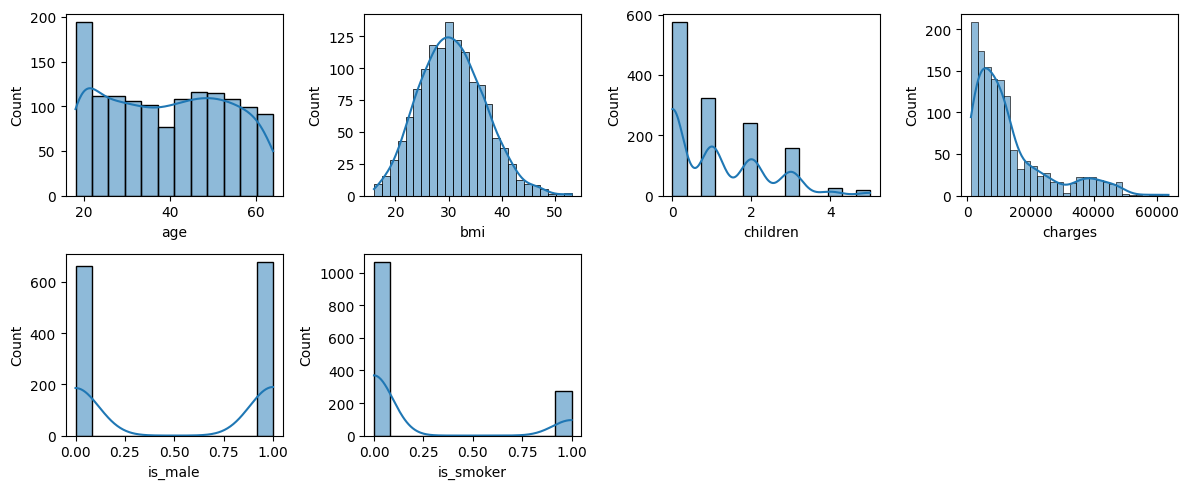

In [14]:
rdu.plot_histograms(data=df, y_var=y_var)
#Krivka regrese je vyrazne rostoucí s promennou is_smoker, pričemž je videt nejakou korelaci i s promennou age a bmi
#, kde je krivka regrese take rostoucí.Teda mužeme rict že pokud je človek kuřak jeho charges jsou vyšši
# a charges se zvyšuji i s rostoucim vekem a bmi .

**ÚKOL:** Jaký tvar má rozdělení proměnné `charges`? (Můžete použít speciální statistické názvosloví určené pro popsání tohoto tvaru, nebo popište rozdělení vlastními slovy).

**ODPOVĚĎ STUDENT** Jedna se o doprava zakrivene rozdeleni so stredni hodnotou kolem 20 000. Nejvice hodnot pro promennu charges je od 0 do 20 000.


# Linerání regrese (regresní úloha)

Pomocí linerání predikce budeme předpovídat hodnotu proměnné `charges`, tedy náklady na péči účtované pojišťovnou.

## Rozdělení na X a y

In [15]:
# dataframe vysvětlujících proměnných X
X_reg = df[['bmi']]  # <-- STUDENT
X_reg.head()


,bmi
0,27.900
1,33.770
2,33.000
3,22.705
4,28.880


In [16]:
# series vysvětlované proměnné y (charges)
y_reg = df['charges']  # <-- STUDENT
y_reg.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

## Rozdělení na train a test

In [17]:
# rodělení na trénovací a testovací množinu
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, random_state=42)

In [18]:
# kontrola velikosti zíkaných datasetů
X_reg_train.shape

(1003, 1)

In [19]:
X_reg_test.shape

(335, 1)

In [20]:
y_reg_train.shape

(1003,)

In [21]:
y_reg_test.shape

(335,)

## Nácvik modelu

In [22]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
# vytvoření objektu regrese
reg = linear_model.LinearRegression() # <-- STUDENT

In [24]:
# nacvik modelu na trénovací množině
reg.fit(X_reg_train,y_reg_train)

LinearRegression()

## Predikce

In [25]:
# predikce na testovací množině
y_reg_pred = reg.predict(X_reg_test)  # <-- STUDENT
y_reg_pred[:5]

array([11173.38063652, 13074.92435683, 11844.51371427, 11397.09166244,
       13820.62777655])

## Vyhodnocení modelu

### Vyhodnocení pomocí R^2 skóre

In [26]:
# r2 skóre na testovací množině, zaokrouhlete na 3 desetinná místa
from sklearn.metrics import r2_score

print('moddel 1 R^2: {:0.3f}'.format(r2_score(y_reg_test, y_reg_pred)) )


moddel 1 R^2: 0.042


### Identifikace vysoce nepřesných predikcí

In [27]:
print(y_reg_test.shape,type(y_reg_test))


(335,) <class 'pandas.core.series.Series'>


In [28]:
print(y_reg_pred.shape,type(y_reg_pred))

(335,) <class 'numpy.ndarray'>


In [29]:
# vypočteme "rezidua", tedy o kolik se liší predikce od skutečnosti
y_test_residuals = y_reg_pred - y_reg_test

In [30]:
# vytvoříme dataframe s původními daty, výsledky a rezidui na testovací množině
reg_results = pd.concat([
    X_reg_test,
    pd.DataFrame({
        'charges_true': y_reg_test,
        'charges_pred': y_reg_pred,
        'residual': y_test_residuals,
        'residual_abs': abs(y_test_residuals)
    })
], axis=1)

In [31]:
reg_results.head()

,bmi,charges_true,charges_pred,residual,residual_abs
764,25.175,9095.06825,11173.380637,2078.312387,2078.312387
887,30.020,5272.17580,13074.924357,7802.748557,7802.748557
890,26.885,29330.98315,11844.513714,-17486.469436,17486.469436
1293,25.745,9301.89355,11397.091662,2095.198112,2095.198112
259,31.920,33750.29180,13820.627777,-19929.664023,19929.664023


In [32]:
# seřaďte dataframe reg_results podle proměnné `residual` sestupně a vypište 3 řádky s nejvyšší chybou
# (tj. seřaďte a např. vypište řádeky .iloc[:3])
reg_results.sort_values(by=['residual_abs'], ascending=False).iloc[:3]

,bmi,charges_true,charges_pred,residual,residual_abs
543,47.41,63770.42801,19900.073025,-43870.354985,43870.354985
175,37.70,48824.45000,16089.136074,-32735.313926,32735.313926
420,33.88,46889.26120,14589.879725,-32299.381475,32299.381475


**ÚKOL:**
Interpretujte jednou větou výsledek výše (tj. jednoduchým jazykem řekněte, co ukazují tři řádky výše).

**ODPOVĚĎ STUDENT** Residua je rozdil mezi skutečnymi hodnotami a hodnotami ktere nam model predpovida.  Takže u techto trech BMI  byly predikovane charges najdalej od skutečnych hodnot zoradene na zaklade ich absolutnich hodnot.

In [33]:
# ze stejného dataframu vypište 3 řádky se nejvyšší zápornou chybou
reg_results.sort_values(by=['residual']).iloc[:3]

,bmi,charges_true,charges_pred,residual,residual_abs
543,47.41,63770.42801,19900.073025,-43870.354985,43870.354985
175,37.70,48824.45000,16089.136074,-32735.313926,32735.313926
420,33.88,46889.26120,14589.879725,-32299.381475,32299.381475


**ÚKOL:**
Interpretujte jednou větou výsledek výše (tj. jednoduchým jazykem řekněte, co ukazují tři řádky výše).

**ODPOVĚĎ STUDENT**  Takže u techto trech BMI  byly predikovane charges najdalej od skutečnych hodnot v zapornych hodnotach.

In [34]:
# seřaďte dataframe reg_results podle proměnné `residual_abs` vzestupně a vypiště 3 řádky s nejnižší absolutní chybou
reg_results.sort_values(by=['residual_abs']).iloc[:3]

,bmi,charges_true,charges_pred,residual,residual_abs
532,29.70,12925.8860,12949.332202,23.446202,23.446202
560,19.95,9193.8385,9122.696232,-71.142268,71.142268
447,25.65,11454.0215,11359.806491,-94.215009,94.215009


In [36]:
# vypočítejte průměrnou hodnotu 'residual_abs'
print('RMSE:', mean_squared_error(y_reg_test, y_reg_pred, squared=False))

RMSE: 12022.409082813892


**ÚKOL:** Interpretujte jednou větou výsledek výše (tj. jednoduchým jazykem řekněte, co znamená vypočtený průměr výše).

**ODPOVĚĎ STUDENT** RMSE nam hovori o velikosti odchylky (chyby) mezi skutečnými a predpovezenymi hodnotami. Čim nižší tim je model presnejši v predikci. Aktualne je RMSE pomerne vysoké a teda model neni moc presny.